In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import sys
import os
import collections
from tqdm import tqdm
HERE = %pwd
sys.path.append(os.path.dirname(HERE))

from IPython.display import display

%matplotlib inline
import matplotlib.pyplot as plt
import copy

import pickle
import time

In [2]:
# functions
from src import utils, main, post_process

In [3]:
# preprocessed directory
version_infer = "20250404_infer"
version_input = "20250403_input"
version_prep = "20250403_prep"
n_user = 200  
n_user_exp = 100

# LLM names
d_model = {
    "gpt-4.1-mini-2025-04-14" : "gpt-4.1-mini",
    "llama3-3-70b-instruct-v1" : "llama3.3-70b", 
    "gpt-4o-mini-2024-07-18" : "gpt-4o-mini", 
    "phi4" : "phi4",
    "nova-lite-v1" : "amazon-nova-lite"
}
model_names = list(d_model.keys())
model_names_short = list(d_model.values())

# data names
data_names = ["Yelp", "MIND", "Food"] + [f"Amazon_{a}" for a in ["Movie", "Music", "Grocery", "Clothes", "Book"]]

# prompt names
# comments are renamed prompt names for submitted paper
types_prompt = [
    f"ItemAll_Method{b}" 
    for b in [
        "Baseline", 
        "Emotion", 
        "Re-Reading",
        "Bothinst",  # Both-Inst
        "RecencyFocused",  # Recency-Focused
        "Pretend",  # RolePlay-User
        "Baseline_SystemRole",  # RolePlay-Expert
        "Baseline_Naming",  # RolePlay-Frederick
        "Baseline_ItemSummary",  # Summarize-Item
        "StepBack",  # Step-Back
        "ReAct",
        "Rephrase",
        "Echo",
        "UserSummarization",  # Summarize-User
        "ItemGenerate",  # Generate-Item
        "ItemGenerateTrue",  # Reuse-Item
        "Explain",
        "Mock",                
        "ZSCoT",  # Step-by-Step
        "TakeBreath",  # Deep-Breath
        "PlanSolve"  # Plan-Solve
    ]
]

# user types
exp_names = ["light", "heavy"]

# nDCG@k, Hit@k
k = 3

# set random seed
utils.set_seed()

In [4]:
# load computed data if exists; run otherwise
ds = dict()
dc = dict()

for model_name, model_name_short in d_model.items():
    print(model_name)
    llm = utils.load_llm(model_name)
    
    dict_res, df_cost = main.run(
        llm=llm, data_names=data_names, types_prompt=types_prompt, exp_names=exp_names, k=k,
        model_name=model_name, version_infer=version_infer, 
        n_user=n_user, version_input=version_input, version_prep=version_prep, n_user_exp=n_user_exp
    )
    
    ds[model_name_short] = dict_res
    dc[model_name_short] = df_cost

gpt-4.1-mini-2025-04-14


100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:36<00:00,  4.56s/it]


finished
llama3-3-70b-instruct-v1


100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:34<00:00,  4.37s/it]


finished
gpt-4o-mini-2024-07-18


100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:52<00:00,  6.53s/it]


finished
phi4


100%|██████████████████████████████████████████████████████████████████████| 8/8 [01:14<00:00,  9.35s/it]


finished
nova-lite-v1


100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:36<00:00,  4.55s/it]


finished


In [5]:
# select mode
# - "latex" will give all table info in latex format
# - "view" will give all table info in pandas dataframe html style
presentation = ["latex", "view"][1]

# Section 4.1
## Table 7

In [6]:
metric = "nDCG"
k = 3

# nDCG@3 for all datasets
d_acc = dict()
d_acc_view = dict()
for model_name in model_names_short:
    d_ = dict()
    for data_name in ["Music", "Movie", "Groceries", "Clothes", "Book", "Yelp", "News", "Food", "Light", "Heavy"]:
        dict_res = ds[model_name]
        df_res = pd.concat(dict_res[f"{metric}@{k}"].values())
        df = post_process.convert_stat_table_with_latex(df_res, l_select=[data_name])
        df_ = df[["tex", "score"]]
        d_[data_name] = df_
        
    d_acc[model_name] = pd.DataFrame({data_name : df_["tex"] for data_name, df_ in d_.items()})
    d_acc_view[model_name] = pd.DataFrame({data_name : df_["score"] for data_name, df_ in d_.items()})

# nDCG@3 for all models by averaging over all datasets
d_ = dict()
for model_name in model_names_short:
    dict_res = ds[model_name]
    df_res = pd.concat(dict_res[f"{metric}@{k}"].values())
    df = post_process.convert_stat_table_with_latex(df_res, l_select=[])
    df_ = df[["tex", "score"]]
    d_[model_name] = df_

df_model = pd.DataFrame({model_name : df_["tex"] for model_name, df_ in d_.items()})

# Section 4.1 : Table 7
if presentation == "latex":
    df = pd.concat([d_acc["gpt-4.1-mini"], df_model], axis=1)
    print(df.to_latex(escape=False))
else:
    df_model = pd.DataFrame({model_name : df_["score"] for model_name, df_ in d_.items()})
    df = pd.concat([d_acc_view["gpt-4.1-mini"], df_model], axis=1)
    display(df.astype(float).round(3))

,Music,Movie,Groceries,Clothes,Book,Yelp,News,Food,Light,Heavy,gpt-4.1-mini,llama3.3-70b,gpt-4o-mini,phi4,amazon-nova-lite
Baseline,0.610,0.516,0.443,0.408,0.585,0.512,0.262,0.328,0.460,0.456,0.458,0.439,0.432,0.417,0.389
Emotion,0.608,0.491,0.438,0.411,0.582,0.503,0.271,0.327,0.461,0.447,0.454,0.442,0.440,0.417,0.376
Re-Reading,0.567,0.487,0.420,0.400,0.553,0.421,0.275,0.304,0.444,0.412,0.428,0.472,0.402,0.409,0.393
Both-Inst,0.609,0.513,0.443,0.398,0.566,0.544,0.226,0.316,0.459,0.444,0.452,0.437,0.430,0.403,0.396
Recency-Focused,0.601,0.519,0.466,0.420,0.591,0.526,0.245,0.361,0.478,0.455,0.466,0.470,0.443,0.409,0.394
RolePlay-User,0.540,0.484,0.372,0.325,0.533,0.500,0.195,0.317,0.420,0.397,0.408,0.447,0.411,0.375,0.391
RolePlay-Expert,0.592,0.507,0.441,0.380,0.587,0.515,0.260,0.305,0.450,0.446,0.448,0.440,0.431,0.415,0.383
RolePlay-Frederick,0.588,0.505,0.441,0.403,0.569,0.511,0.261,0.303,0.451,0.445,0.448,0.437,0.426,0.418,0.379
Summarize-Item,0.536,0.495,0.401,0.421,0.536,0.481,0.234,0.318,0.431,0.424,0.428,0.446,0.427,0.371,0.378
Step-Back,0.642,0.561,0.469,0.437,0.594,0.521,0.246,0.340,0.480,0.473,0.476,0.481,0.460,0.436,0.348


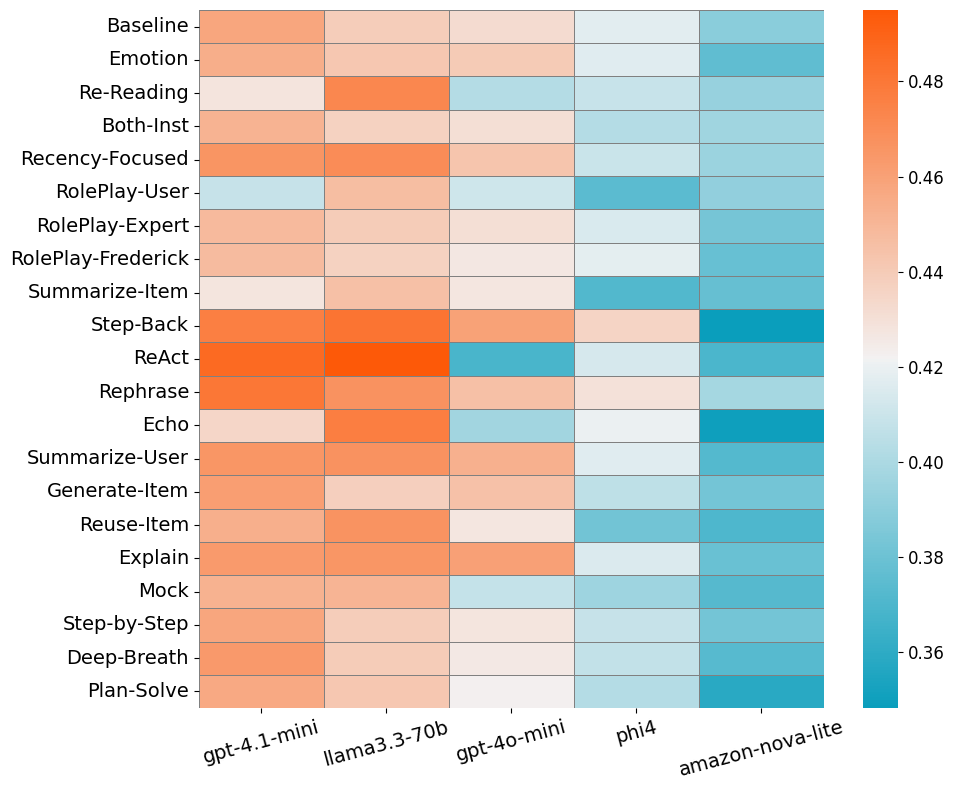

In [7]:
# [unused figure] heatmap 
def _plot(df, path_save=""):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import matplotlib.colors as mcolors

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        df, 
        cmap=sns.diverging_palette(220, 20, as_cmap=True, s=99, l=60, center="light"),
        cbar=True, linewidths=0.5, linecolor='gray'
    )

    cbar = plt.gcf().axes[-1]
    cbar.yaxis.label.set_size(12)
    cbar.tick_params(labelsize=12)
    
    plt.xticks(rotation=15, fontsize=14)
    plt.yticks(rotation=0, fontsize=14)
    plt.tight_layout()
    plt.savefig(path_save, transparent=True, bbox_inches='tight')
    plt.show()

df = pd.DataFrame({model_name : df_["score"] for model_name, df_ in d_.items()}).astype(float)
_plot(df, path_save="heatmap_abs.png")

## Supplementary material (Table 1-4)

In [8]:
# nDCG@3 for all models
for model_name, df in d_acc.items():
    print(model_name)
    print("- " * 50)

    if presentation == "latex":
        print(df.to_latex(escape=False))
    else:
        df = d_acc_view[model_name]
        display(df.astype(float).round(3))
    print("\n")

gpt-4.1-mini
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,Music,Movie,Groceries,Clothes,Book,Yelp,News,Food,Light,Heavy
Baseline,0.610,0.516,0.443,0.408,0.585,0.512,0.262,0.328,0.460,0.456
Emotion,0.608,0.491,0.438,0.411,0.582,0.503,0.271,0.327,0.461,0.447
Re-Reading,0.567,0.487,0.420,0.400,0.553,0.421,0.275,0.304,0.444,0.412
Both-Inst,0.609,0.513,0.443,0.398,0.566,0.544,0.226,0.316,0.459,0.444
Recency-Focused,0.601,0.519,0.466,0.420,0.591,0.526,0.245,0.361,0.478,0.455
RolePlay-User,0.540,0.484,0.372,0.325,0.533,0.500,0.195,0.317,0.420,0.397
RolePlay-Expert,0.592,0.507,0.441,0.380,0.587,0.515,0.260,0.305,0.450,0.446
RolePlay-Frederick,0.588,0.505,0.441,0.403,0.569,0.511,0.261,0.303,0.451,0.445
Summarize-Item,0.536,0.495,0.401,0.421,0.536,0.481,0.234,0.318,0.431,0.424
Step-Back,0.642,0.561,0.469,0.437,0.594,0.521,0.246,0.340,0.480,0.473




llama3.3-70b
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,Music,Movie,Groceries,Clothes,Book,Yelp,News,Food,Light,Heavy
Baseline,0.605,0.506,0.478,0.408,0.574,0.475,0.157,0.312,0.440,0.439
Emotion,0.607,0.514,0.484,0.406,0.575,0.484,0.177,0.290,0.439,0.445
Re-Reading,0.631,0.526,0.554,0.441,0.577,0.507,0.233,0.308,0.471,0.474
Both-Inst,0.607,0.502,0.495,0.404,0.561,0.507,0.169,0.248,0.437,0.436
Recency-Focused,0.627,0.523,0.495,0.473,0.601,0.468,0.248,0.324,0.467,0.473
RolePlay-User,0.606,0.512,0.482,0.446,0.560,0.481,0.169,0.315,0.461,0.432
RolePlay-Expert,0.597,0.516,0.490,0.400,0.561,0.490,0.154,0.313,0.439,0.441
RolePlay-Frederick,0.605,0.505,0.480,0.385,0.566,0.472,0.160,0.319,0.435,0.438
Summarize-Item,0.586,0.495,0.451,0.441,0.573,0.453,0.284,0.281,0.459,0.432
Step-Back,0.622,0.578,0.473,0.458,0.621,0.553,0.208,0.338,0.480,0.483




gpt-4o-mini
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,Music,Movie,Groceries,Clothes,Book,Yelp,News,Food,Light,Heavy
Baseline,0.541,0.502,0.440,0.393,0.518,0.501,0.200,0.364,0.444,0.421
Emotion,0.561,0.527,0.445,0.400,0.543,0.479,0.204,0.360,0.450,0.430
Re-Reading,0.456,0.483,0.471,0.377,0.436,0.439,0.219,0.335,0.431,0.374
Both-Inst,0.586,0.484,0.437,0.397,0.520,0.485,0.194,0.341,0.432,0.429
Recency-Focused,0.565,0.497,0.466,0.398,0.532,0.480,0.230,0.375,0.449,0.437
RolePlay-User,0.591,0.492,0.358,0.344,0.545,0.493,0.116,0.348,0.426,0.396
RolePlay-Expert,0.566,0.503,0.441,0.383,0.513,0.505,0.191,0.344,0.443,0.418
RolePlay-Frederick,0.556,0.487,0.445,0.376,0.517,0.481,0.205,0.345,0.430,0.423
Summarize-Item,0.546,0.465,0.407,0.392,0.558,0.485,0.200,0.367,0.441,0.414
Step-Back,0.581,0.570,0.457,0.423,0.545,0.455,0.270,0.375,0.465,0.454




phi4
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,Music,Movie,Groceries,Clothes,Book,Yelp,News,Food,Light,Heavy
Baseline,0.591,0.462,0.464,0.471,0.595,0.331,0.145,0.278,0.423,0.411
Emotion,0.573,0.446,0.483,0.451,0.580,0.352,0.131,0.319,0.428,0.406
Re-Reading,0.540,0.457,0.478,0.469,0.533,0.306,0.244,0.244,0.432,0.386
Both-Inst,0.553,0.455,0.462,0.435,0.580,0.360,0.083,0.293,0.417,0.388
Recency-Focused,0.562,0.455,0.457,0.429,0.598,0.352,0.131,0.292,0.424,0.395
RolePlay-User,0.529,0.423,0.395,0.399,0.573,0.320,0.042,0.316,0.391,0.358
RolePlay-Expert,0.581,0.461,0.469,0.451,0.592,0.322,0.132,0.310,0.423,0.406
RolePlay-Frederick,0.568,0.475,0.470,0.440,0.561,0.382,0.152,0.295,0.435,0.401
Summarize-Item,0.434,0.418,0.395,0.422,0.511,0.372,0.118,0.302,0.377,0.366
Step-Back,0.530,0.467,0.398,0.373,0.493,0.330,0.605,0.290,0.447,0.424




amazon-nova-lite
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,Music,Movie,Groceries,Clothes,Book,Yelp,News,Food,Light,Heavy
Baseline,0.441,0.401,0.414,0.367,0.470,0.447,0.267,0.305,0.360,0.418
Emotion,0.425,0.418,0.382,0.385,0.461,0.404,0.265,0.266,0.347,0.404
Re-Reading,0.509,0.381,0.421,0.378,0.494,0.389,0.316,0.258,0.379,0.408
Both-Inst,0.426,0.413,0.379,0.412,0.475,0.433,0.383,0.249,0.364,0.429
Recency-Focused,0.481,0.415,0.412,0.433,0.450,0.402,0.272,0.289,0.357,0.432
RolePlay-User,0.428,0.431,0.331,0.369,0.426,0.425,0.439,0.280,0.372,0.411
RolePlay-Expert,0.478,0.440,0.387,0.392,0.442,0.397,0.254,0.273,0.358,0.408
RolePlay-Frederick,0.457,0.393,0.380,0.404,0.427,0.437,0.289,0.241,0.354,0.403
Summarize-Item,0.443,0.447,0.356,0.373,0.428,0.404,0.262,0.310,0.355,0.400
Step-Back,0.378,0.384,0.325,0.302,0.345,0.323,0.517,0.213,0.344,0.353


## Supplementary material (Table 5-14)

In [9]:
metric = "nDCG"
k = 3

# nDCG@3 for all datasets
d_acc = dict()
d_acc_view = dict()
for data_name in ["Music", "Movie", "Groceries", "Clothes", "Book", "Yelp", "News", "Food", "Light", "Heavy"]:
    d_ = dict()
    for model_name in model_names_short:
        dict_res = ds[model_name]
        df_res = pd.concat(dict_res[f"{metric}@{k}"].values())
        df = post_process.convert_stat_table_with_latex(df_res, l_select=[data_name])
        df_ = df[["tex", "score"]]
        d_[model_name] = df_
        
    d_acc[data_name] = pd.DataFrame({model_name : df_["tex"] for model_name, df_ in d_.items()})
    d_acc_view[data_name] = pd.DataFrame({model_name : df_["score"] for model_name, df_ in d_.items()})

# nDCG@3 for all models
for data_name, df in d_acc.items():
    print(data_name)
    print("- " * 50)

    if presentation == "latex":
        print(df.to_latex(escape=False))
    else:
        df = d_acc_view[data_name]
        display(df.astype(float).round(3))
    print("\n")

Music
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,gpt-4.1-mini,llama3.3-70b,gpt-4o-mini,phi4,amazon-nova-lite
Baseline,0.610,0.605,0.541,0.591,0.441
Emotion,0.608,0.607,0.561,0.573,0.425
Re-Reading,0.567,0.631,0.456,0.540,0.509
Both-Inst,0.609,0.607,0.586,0.553,0.426
Recency-Focused,0.601,0.627,0.565,0.562,0.481
RolePlay-User,0.540,0.606,0.591,0.529,0.428
RolePlay-Expert,0.592,0.597,0.566,0.581,0.478
RolePlay-Frederick,0.588,0.605,0.556,0.568,0.457
Summarize-Item,0.536,0.586,0.546,0.434,0.443
Step-Back,0.642,0.622,0.581,0.530,0.378




Movie
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,gpt-4.1-mini,llama3.3-70b,gpt-4o-mini,phi4,amazon-nova-lite
Baseline,0.516,0.506,0.502,0.462,0.401
Emotion,0.491,0.514,0.527,0.446,0.418
Re-Reading,0.487,0.526,0.483,0.457,0.381
Both-Inst,0.513,0.502,0.484,0.455,0.413
Recency-Focused,0.519,0.523,0.497,0.455,0.415
RolePlay-User,0.484,0.512,0.492,0.423,0.431
RolePlay-Expert,0.507,0.516,0.503,0.461,0.440
RolePlay-Frederick,0.505,0.505,0.487,0.475,0.393
Summarize-Item,0.495,0.495,0.465,0.418,0.447
Step-Back,0.561,0.578,0.570,0.467,0.384




Groceries
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,gpt-4.1-mini,llama3.3-70b,gpt-4o-mini,phi4,amazon-nova-lite
Baseline,0.443,0.478,0.440,0.464,0.414
Emotion,0.438,0.484,0.445,0.483,0.382
Re-Reading,0.420,0.554,0.471,0.478,0.421
Both-Inst,0.443,0.495,0.437,0.462,0.379
Recency-Focused,0.466,0.495,0.466,0.457,0.412
RolePlay-User,0.372,0.482,0.358,0.395,0.331
RolePlay-Expert,0.441,0.490,0.441,0.469,0.387
RolePlay-Frederick,0.441,0.480,0.445,0.470,0.380
Summarize-Item,0.401,0.451,0.407,0.395,0.356
Step-Back,0.469,0.473,0.457,0.398,0.325




Clothes
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,gpt-4.1-mini,llama3.3-70b,gpt-4o-mini,phi4,amazon-nova-lite
Baseline,0.408,0.408,0.393,0.471,0.367
Emotion,0.411,0.406,0.400,0.451,0.385
Re-Reading,0.400,0.441,0.377,0.469,0.378
Both-Inst,0.398,0.404,0.397,0.435,0.412
Recency-Focused,0.420,0.473,0.398,0.429,0.433
RolePlay-User,0.325,0.446,0.344,0.399,0.369
RolePlay-Expert,0.380,0.400,0.383,0.451,0.392
RolePlay-Frederick,0.403,0.385,0.376,0.440,0.404
Summarize-Item,0.421,0.441,0.392,0.422,0.373
Step-Back,0.437,0.458,0.423,0.373,0.302




Book
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,gpt-4.1-mini,llama3.3-70b,gpt-4o-mini,phi4,amazon-nova-lite
Baseline,0.585,0.574,0.518,0.595,0.470
Emotion,0.582,0.575,0.543,0.580,0.461
Re-Reading,0.553,0.577,0.436,0.533,0.494
Both-Inst,0.566,0.561,0.520,0.580,0.475
Recency-Focused,0.591,0.601,0.532,0.598,0.450
RolePlay-User,0.533,0.560,0.545,0.573,0.426
RolePlay-Expert,0.587,0.561,0.513,0.592,0.442
RolePlay-Frederick,0.569,0.566,0.517,0.561,0.427
Summarize-Item,0.536,0.573,0.558,0.511,0.428
Step-Back,0.594,0.621,0.545,0.493,0.345




Yelp
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,gpt-4.1-mini,llama3.3-70b,gpt-4o-mini,phi4,amazon-nova-lite
Baseline,0.512,0.475,0.501,0.331,0.447
Emotion,0.503,0.484,0.479,0.352,0.404
Re-Reading,0.421,0.507,0.439,0.306,0.389
Both-Inst,0.544,0.507,0.485,0.360,0.433
Recency-Focused,0.526,0.468,0.480,0.352,0.402
RolePlay-User,0.500,0.481,0.493,0.320,0.425
RolePlay-Expert,0.515,0.490,0.505,0.322,0.397
RolePlay-Frederick,0.511,0.472,0.481,0.382,0.437
Summarize-Item,0.481,0.453,0.485,0.372,0.404
Step-Back,0.521,0.553,0.455,0.330,0.323




News
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,gpt-4.1-mini,llama3.3-70b,gpt-4o-mini,phi4,amazon-nova-lite
Baseline,0.262,0.157,0.200,0.145,0.267
Emotion,0.271,0.177,0.204,0.131,0.265
Re-Reading,0.275,0.233,0.219,0.244,0.316
Both-Inst,0.226,0.169,0.194,0.083,0.383
Recency-Focused,0.245,0.248,0.230,0.131,0.272
RolePlay-User,0.195,0.169,0.116,0.042,0.439
RolePlay-Expert,0.260,0.154,0.191,0.132,0.254
RolePlay-Frederick,0.261,0.160,0.205,0.152,0.289
Summarize-Item,0.234,0.284,0.200,0.118,0.262
Step-Back,0.246,0.208,0.270,0.605,0.517




Food
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,gpt-4.1-mini,llama3.3-70b,gpt-4o-mini,phi4,amazon-nova-lite
Baseline,0.328,0.312,0.364,0.278,0.305
Emotion,0.327,0.290,0.360,0.319,0.266
Re-Reading,0.304,0.308,0.335,0.244,0.258
Both-Inst,0.316,0.248,0.341,0.293,0.249
Recency-Focused,0.361,0.324,0.375,0.292,0.289
RolePlay-User,0.317,0.315,0.348,0.316,0.280
RolePlay-Expert,0.305,0.313,0.344,0.310,0.273
RolePlay-Frederick,0.303,0.319,0.345,0.295,0.241
Summarize-Item,0.318,0.281,0.367,0.302,0.310
Step-Back,0.340,0.338,0.375,0.290,0.213




Light
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,gpt-4.1-mini,llama3.3-70b,gpt-4o-mini,phi4,amazon-nova-lite
Baseline,0.460,0.440,0.444,0.423,0.360
Emotion,0.461,0.439,0.450,0.428,0.347
Re-Reading,0.444,0.471,0.431,0.432,0.379
Both-Inst,0.459,0.437,0.432,0.417,0.364
Recency-Focused,0.478,0.467,0.449,0.424,0.357
RolePlay-User,0.420,0.461,0.426,0.391,0.372
RolePlay-Expert,0.450,0.439,0.443,0.423,0.358
RolePlay-Frederick,0.451,0.435,0.430,0.435,0.354
Summarize-Item,0.431,0.459,0.441,0.377,0.355
Step-Back,0.480,0.480,0.465,0.447,0.344




Heavy
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,gpt-4.1-mini,llama3.3-70b,gpt-4o-mini,phi4,amazon-nova-lite
Baseline,0.456,0.439,0.421,0.411,0.418
Emotion,0.447,0.445,0.430,0.406,0.404
Re-Reading,0.412,0.474,0.374,0.386,0.408
Both-Inst,0.444,0.436,0.429,0.388,0.429
Recency-Focused,0.455,0.473,0.437,0.395,0.432
RolePlay-User,0.397,0.432,0.396,0.358,0.411
RolePlay-Expert,0.446,0.441,0.418,0.406,0.408
RolePlay-Frederick,0.445,0.438,0.423,0.401,0.403
Summarize-Item,0.424,0.432,0.414,0.366,0.400
Step-Back,0.473,0.483,0.454,0.424,0.353


## Supplementary material (Table 15)

In [10]:
metric = "Hit"
k = 3

# Hit@3 for all datasets
d_acc = dict()
d_acc_view = dict()
for model_name in model_names_short:
    d_ = dict()
    for data_name in ["Music", "Movie", "Groceries", "Clothes", "Book", "Yelp", "News", "Food", "Light", "Heavy"]:
        dict_res = ds[model_name]
        df_res = pd.concat(dict_res[f"{metric}@{k}"].values())
        df = post_process.convert_stat_table_with_latex(df_res, l_select=[data_name])
        df_ = df[["tex", "score"]]
        d_[data_name] = df_
        
    d_acc[model_name] = pd.DataFrame({data_name : df_["tex"] for data_name, df_ in d_.items()})
    d_acc_view[model_name] = pd.DataFrame({data_name : df_["score"] for data_name, df_ in d_.items()})

# Hit@3 for all models by averaging over all datasets
d_ = dict()
for model_name in model_names_short:
    dict_res = ds[model_name]
    df_res = pd.concat(dict_res[f"{metric}@{k}"].values())
    df = post_process.convert_stat_table_with_latex(df_res, l_select=[])
    df_ = df[["tex", "score"]]
    d_[model_name] = df_

df_model = pd.DataFrame({model_name : df_["tex"] for model_name, df_ in d_.items()})

if presentation == "latex":
    df = pd.concat([d_acc["gpt-4.1-mini"], df_model], axis=1)
    print(df.to_latex(escape=False))
else:
    df_model = pd.DataFrame({model_name : df_["score"] for model_name, df_ in d_.items()})
    df = pd.concat([d_acc_view["gpt-4.1-mini"], df_model], axis=1)
    display(df.astype(float).round(3))

,Music,Movie,Groceries,Clothes,Book,Yelp,News,Food,Light,Heavy,gpt-4.1-mini,llama3.3-70b,gpt-4o-mini,phi4,amazon-nova-lite
Baseline,0.720,0.595,0.525,0.520,0.675,0.680,0.380,0.445,0.568,0.568,0.568,0.543,0.537,0.514,0.498
Emotion,0.715,0.565,0.535,0.505,0.675,0.665,0.390,0.440,0.569,0.554,0.561,0.551,0.543,0.519,0.480
Re-Reading,0.690,0.605,0.520,0.500,0.630,0.545,0.390,0.400,0.555,0.515,0.535,0.586,0.493,0.509,0.511
Both-Inst,0.715,0.595,0.550,0.505,0.645,0.710,0.340,0.425,0.570,0.551,0.561,0.540,0.524,0.498,0.505
Recency-Focused,0.695,0.590,0.555,0.525,0.665,0.680,0.360,0.470,0.580,0.555,0.568,0.570,0.539,0.511,0.504
RolePlay-User,0.630,0.570,0.460,0.385,0.605,0.665,0.290,0.435,0.515,0.495,0.505,0.551,0.500,0.467,0.506
RolePlay-Expert,0.710,0.590,0.555,0.485,0.685,0.685,0.375,0.405,0.564,0.559,0.561,0.547,0.529,0.510,0.496
RolePlay-Frederick,0.700,0.600,0.545,0.505,0.655,0.670,0.380,0.405,0.569,0.546,0.558,0.542,0.524,0.518,0.489
Summarize-Item,0.635,0.595,0.505,0.535,0.650,0.645,0.340,0.405,0.538,0.540,0.539,0.548,0.524,0.471,0.486
Step-Back,0.755,0.665,0.600,0.560,0.695,0.690,0.350,0.440,0.596,0.592,0.594,0.588,0.564,0.528,0.439


## Table 8

,gpt-4.1-mini,llama3.3-70b,gpt-4o-mini,phi4,amazon-nova-lite
Rephrase,4.46,5.91,2.44,2.97,1.74
Step-Back,4.35,8.93,5.64,3.62,-11.15
Explain,1.01,6.07,5.31,-0.17,-2.28
Summarize-User,1.22,5.85,4.32,0.54,-5.19
Recency-Focused,0.90,5.95,1.45,-1.22,1.37
ReAct,5.84,11.97,-13.79,-0.17,-5.26
Generate-Item,0.36,-0.21,2.27,-2.31,-0.90
Both-Inst,-1.29,-0.58,-1.39,-3.31,1.69
Baseline,0.00,0.00,0.00,0.00,0.00
Step-by-Step,-0.28,-0.08,-1.65,-1.61,-1.88


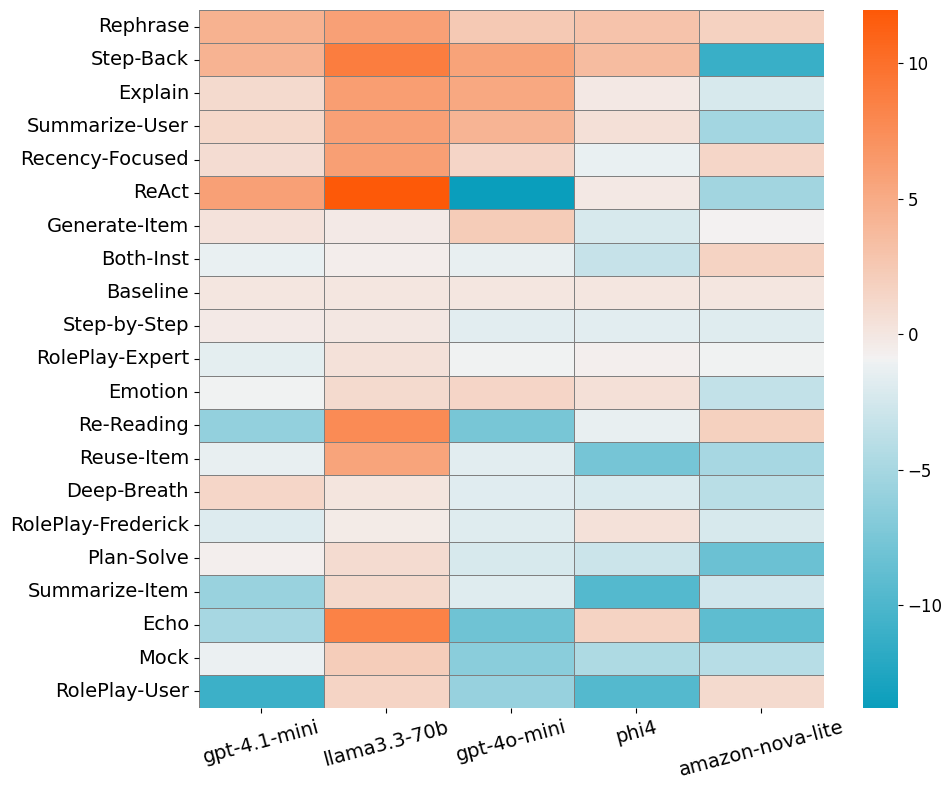

In [11]:
# improvement rate

dict_imp_p = dict()
for data_type in ["Light", "Heavy", "_"]:
    dd = dict()
    for model_name in model_names_short:
        dr = {"imp" : dict(), "p" : dict(), "p_n" : dict()}
        for metric in ["nDCG", "Hit"]:
            dict_res = ds[model_name]
            df_res = pd.concat(dict_res[f"{metric}@{k}"].values())
            df = post_process.convert_stat_table_with_latex(df_res, l_select=[data_type])
            # improvement rate
            s_imp = df["imp"].astype(float)

            # p-value by Wilcoxon test proposed > baseline
            s_ = df["p value pos"].astype(float)
            s = pd.Series(0, index=s_.index)
            s[s_<0.05] = 1
            s_p = s.copy()

            # p-value by Wilcoxon test proposed < baseline
            s_ = df["p value neg"].astype(float)
            s = pd.Series(0, index=s_.index)
            s[s_<0.05] = -1
            s_n = s.copy()

            dr["imp"][f"{metric}@{k}"] = s_imp
            dr["p"][f"{metric}@{k}"] = s_p
            dr["p_n"][f"{metric}@{k}"] = s_n
    
        df = pd.DataFrame(dr["imp"])
        s_imp = 100 * df.T.mean()
    
        df = pd.DataFrame(dr["p"])
        s_p = df.T.sum()
        
        df = pd.DataFrame(dr["p_n"])
        s_n = df.T.sum()

        dd[model_name] = pd.DataFrame({
            "imp" : s_imp,
            "p" : (s_p + s_n)
        })
    
    dd["All"] = pd.DataFrame({
        "imp" : pd.DataFrame({model_name : df["imp"] for model_name, df in dd.items()}).T.mean(),
        "p" : pd.DataFrame({model_name : df["p"] for model_name, df in dd.items()}).T.sum()
    })
    
    df = pd.concat(dd, axis=1)
    if data_type == "_":
        data_type = "ALL"
    dict_imp_p[data_type] = df

# color map to each cell in LaTeX
def _f(imp):
    if imp > 0.1:
        f = "\cellcolor{pshigh}"
    elif imp > 0.07:
        f = "\cellcolor{phigh}"
    elif imp > 0.05:
        f = "\cellcolor{pmiddle}"
    elif imp > 0.03:
        f = "\cellcolor{plow}"
    elif imp > 0.01:
        f = "\cellcolor{pslow}"
    elif imp < -0.1:
        f = "\cellcolor{nshigh}"
    elif imp < -0.07:
        f = "\cellcolor{nhigh}"
    elif imp < -0.05:
        f = "\cellcolor{nmiddle}"
    elif imp < -0.03:
        f = "\cellcolor{nlow}"
    elif imp < -0.01:
        f = "\cellcolor{nslow}"
    else:
        f = ""
    return f


# statistical test symbol for each model
def _tmp(v):
    v = v.values
    a = int(v[1])
    if a >= 2:
        a = "^{*}"
    elif a <= -2:
        a = "^{\\bigtriangledown}"
    else:
        a = ""    
    
    return f"{_f(v[0]/100)}${v[0]:.1f}{a}$"

d_ = dict()
for model_name in model_names_short:
    df = dict_imp_p["ALL"][model_name]
    d_[model_name] = df.T.apply(_tmp)

# statistical test symbol for each prompt by summarizing all models
def _tmp2(v):
    v = v.values
    a = int(v[1])
    if a != 0:
        a = f" ({a})"
    else:
        a = ""
    return f"{_f(v[0]/100)}${v[0]:.1f}{a}$"

for data_type in ["ALL"]:
    df = dict_imp_p[data_type]["All"]
    d_[data_type] = df.T.apply(_tmp2)

df = pd.concat(d_, axis=1)
df = df.loc[dict_imp_p[data_type]["All"]["p"].sort_values(ascending=False).index]

# Section 4.1 : Table 8
if presentation == "latex":
    print(df.to_latex(escape=False))

# heatmap
d_ = dict()
for model_name in model_names_short:
    df = dict_imp_p["ALL"][model_name]
    d_[model_name] = df.T.apply(lambda s : s.values[0])
df = pd.concat(d_, axis=1)
df = df.loc[dict_imp_p["ALL"]["All"]["p"].sort_values(ascending=False).index]
display(df.astype(float).round(2))
_plot(df, path_save="heatmap_imp.png")

# Section 4.2

## Table 9

In [12]:
# LMEM
df_long_all = post_process.convert_long_table(ds, k=k, metrics=["nDCG", "Hit"])

d_lmem = dict()
for data_name in tqdm(["Music", "Movie", "Groceries", "Clothes", "Book", "Yelp", "News", "Food", "Light", "Heavy", "_"]):
    df_ = df_long_all.copy()
    df_long = df_.iloc[[
        i for i, u in df_["user"].to_dict().items() 
        if data_name in u.split("__DataName")[1]
    ]]
    s_pos, s_neg = post_process.lmem(df_long)
    
    if data_name == "_":
        data_name = "ALL"
    
    d_lmem[data_name] = {
        "pos" : s_pos, 
        "neg" : s_neg
    }

d_pos = {data_name : ", ".join(d["pos"].index.values) for data_name, d in d_lmem.items()}
d_neg = {data_name : ", ".join(d["neg"].index.values) for data_name, d in d_lmem.items()}
df = pd.concat([pd.Series(d_pos), pd.Series(d_neg)], axis=1)
df.columns = ["Positive", "Negative"]

# Section 4.2 : Table 9
if presentation == "latex":
    print(df.to_latex(escape=False))
else:
    display(df)

100%|████████████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.46s/it]


,Positive,Negative
Music,,"Summarize-Item, RolePlay-User, Re-Reading"
Movie,"ReAct, Rephrase",
Groceries,ReAct,RolePlay-User
Clothes,,RolePlay-User
Book,Rephrase,"RolePlay-User, Summarize-Item"
Yelp,,"Re-Reading, Echo"
News,,RolePlay-User
Food,,Echo
Light,Rephrase,"RolePlay-User, Summarize-Item, Echo"
Heavy,ReAct,"Re-Reading, RolePlay-User, Summarize-Item"
